In [7]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from utils import *
from glob import glob
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

def loadPreComputedCP(tensorname,basedir,specificFs=[],NMODES=3,verbose=True):
    
    """Converts the .mat files produced by tensor decomposition (see `matlab/run_permcp.m`)
    and aggregates the results from multiple choices of F (number of components) and
    initializations into a single Python dict."""
    
    
    preComputed = {}

    #parse the F (# of factors) from the file name
    def parseF(s):
        assert s[-4:] == '.mat'
        extn = 4
        F_str = s[:-extn].split('_F')[-1]
        return int(F_str)
    
    query = '%s/%s*_F*.mat' % (basedir,tensorname)
 
    queryfiles = glob(query)

    F_ = None
    counted_reps = 0
    for r in sorted(queryfiles):
        
        F = parseF(r)

        if specificFs and F not in specificFs:
            continue

        if F != F_:
            if int(verbose) > 1:
                print()
            elif int(verbose) == 1 and counted_reps > 0:
                print(f'({counted_reps})',end=' ')
            
            counted_reps = 0 #reset
            
            if verbose: print(f'F{F}:',end=' ')
            F_ = F
        #if another file from the same F, keep updating the number of reps
        


        matfile = loadmat(r)
        assert matfile['factors'][0,0].shape[1] == NMODES

        nreps = len(matfile['factors'][0])

        factors = {counted_reps+rep:matfile['factors'][0][rep].squeeze() for rep in range(nreps)}
        lambdas = {counted_reps+rep:matfile['lams'][0][rep].squeeze() for rep in range(nreps)}
        objs = {counted_reps+rep:matfile['objs'][0][rep].squeeze() for rep in range(nreps)}


        F_precomp = {'all_factors':factors, 'all_lambdas':lambdas, 'all_objs':objs}


        counted_reps += nreps
        
        if F not in preComputed:
            preComputed[F] = F_precomp.copy()

        else:#merge results
            for dkey in F_precomp.keys():
                preComputed[F][dkey].update(F_precomp[dkey])

    if int(verbose) == 1 and counted_reps > 0:
        print(f'({counted_reps})')
        
    Fs = sorted(preComputed.keys())
    return preComputed,Fs

#### 1. Load pre-computed CP decomposition results

In [ ]:
tensorname = 'base-tensor-name'#input tensor base filename
basedir = 'cp-files'#where to find the .mat files produced by the permuted tensor decomposition
#each .mat file should have the format: "{base-tensor-name}_rank_{# factors chosen}"
preComputed,Fs = loadPreComputedCP(tensorname,basedir)

#### 2. Plot statistics to help choose an appropriate number of components

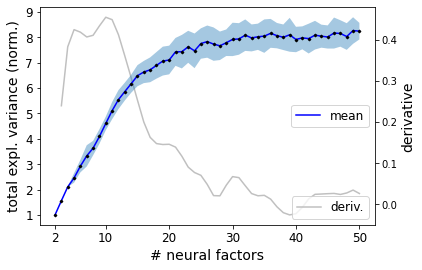

In [12]:
#plot total normalized explained variance (nuclear norm) for each F

nfacs = np.array(Fs)
NEURALMODE = 0
mus = []

stds = []

LGD_SZ = 12
LBL_SZ = 14
TICK_SZ = 12

for nf in nfacs:
    #collect factors for all available repetitions
    neuralfs = np.array([preComputed[nf]['all_factors'][repi][NEURALMODE] for repi in sorted(preComputed[nf]['all_factors'])])
    #normalize
    neuralfs = [f/from0to1(np.linalg.norm(f,axis=0,keepdims=1)) for f in neuralfs]
    
    nucl_norms = []
    
    reps_used = list(preComputed[nf]['all_lambdas'])###
    
    for repi in range(len(preComputed[nf]['all_factors'])):

        A = neuralfs[repi].copy()
        Si = A.T
        Si -= Si.mean(0)
        #compute explained variances
        s = np.linalg.svd(Si,full_matrices=False,compute_uv=False)
        var = s**2/(Si.shape[0]-1)   
        #normalize
        var /= var.max()
        # compute nuclear norm (sum of eigenvals)
        nucl_norms.append( var.sum() )

    mus.append(np.mean(nucl_norms))
    stds.append(np.std(nucl_norms))

f,ax1 = subps(1,1,4,6)
ax1.plot(nfacs, mus,'b-', label='mean')
ax1.plot(nfacs, mus,'kD',markersize=2)

mus = np.array(mus)
grads = np.diff(gaussian_filter1d(mus,1.5))
ax1_ = ax1.twinx()
ax1_.plot(nfacs[1:],grads,c='silver',label='deriv.',zorder=0)
ax1_.set_ylabel('derivative',size=LBL_SZ)
ax1_.legend(loc="lower right",fontsize=LGD_SZ)
stds = np.array(stds)
ax1.fill_between(nfacs,mus-stds,mus+stds,alpha=.4)
ax1.set_xlabel('# neural factors',size=LBL_SZ)
ax1.set_ylabel('total expl. variance (norm.)',size=LBL_SZ)
ax1.set_xticks([2]+list(range(10,51,10)))
ax1.tick_params(labelsize=TICK_SZ)
ax1.legend(loc="center right",fontsize=LGD_SZ)
ax1.set_zorder(ax1_.get_zorder()+1)
ax1.set_frame_on(False)

plt.show()

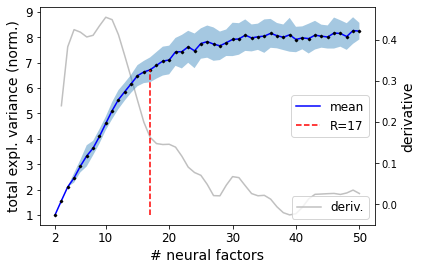

In [10]:

R = 17 #find this based on plot above
#replot, highlighting choice for "rank", R


f,ax1 = subps(1,1,4,6)
ax1.plot(nfacs, mus,'b-', label='mean')
ax1.plot(nfacs, mus,'kD',markersize=2)

mus = np.array(mus)
ax1.plot([R,R],[mus.min(),mus[list(nfacs).index(R)]],'r--',label=f'R={R}',zorder=10)
grads = np.diff(gaussian_filter1d(mus,1.5))
ax1_ = ax1.twinx()
ax1_.plot(nfacs[1:],grads,c='silver',label='deriv.',zorder=0)
ax1_.set_ylabel('derivative',size=LBL_SZ)
ax1_.legend(loc="lower right",fontsize=LGD_SZ)
stds = np.array(stds)
ax1.fill_between(nfacs,mus-stds,mus+stds,alpha=.4)
ax1.set_xlabel('# neural factors',size=LBL_SZ)
ax1.set_ylabel('total expl. variance (norm.)',size=LBL_SZ)
ax1.set_xticks([2]+list(range(10,51,10)))
ax1.tick_params(labelsize=TICK_SZ)
ax1.legend(loc="center right",fontsize=LGD_SZ)
ax1.set_zorder(ax1_.get_zorder()+1)
ax1.set_frame_on(False)

plt.show()

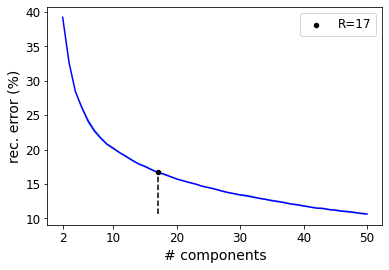

In [11]:
# plot mean error for each choice of F (number of components)
# (in general this is not very helpful to decide on R, so we use the approach above)

LBLSIZE = 14
LGD_SZ = 12
TICK_SZ = 12
LBL_SZ = 14

f,(ax) = subps(1,1,4,6)
objs = np.array([np.mean(list(preComputed[F]['all_objs'].values())) for F in Fs])
stds = np.array([np.std(list(preComputed[F]['all_objs'].values())) for F in Fs])
ax.plot(Fs,objs,'b-',)
ax.fill_between(Fs,objs-stds,objs+stds,alpha=.4)

ax.plot([R,R],[np.min(objs),objs[list(Fs).index(R)]],'k--')
ax.scatter([R],[objs[list(Fs).index(R)]],c='k',s=20,label=f'R={R}',zorder=5)

ax.legend(fontsize=LGD_SZ)
ax.tick_params(labelsize=TICK_SZ)
ax.set_ylabel('rec. error (%)',size=LBL_SZ)
ax.set_xlabel('# components',size=LBL_SZ)
ax.set_xticks([2]+list(range(10,51,10)))

plt.show()

#### 3. Select a specific decomposition instance for a given choice of R

In [19]:
# Because multiple random initializations were computed for the same number of components R, we must now choose one of them.
# A natural choice is to use that with lowest reconstruction error.
# This is information is easy to retrieve using our preComputed dict:

rep, error = min(preComputed[R]['all_objs'].items(), key=lambda x: x[1])
print(f'The repetition with min error was #{rep} (% error = {error:.3f})')

# (Another possibility is to combine the information present across initializations;
# this is mentioned in the `encoding-manifold/encoding-manifold.ipynb` notebook.)

The repetition with min error was #29 (% error = 16.529)
